# Comparison wind and surge data
This notebook compares the performance of two variants of the sea level rise (SLR) regression model. 
- The first variant includes wind data (wind speed and wind direction) as an explanatory variable.
- The second variant corrects the water levels for the (modelled) storm surges. To improve our understanding of the model we consider the correlation between storm surges and water levels (and also the residuals from the regression model without wind) and we add the storm surge as an explanatory variable to the model.

In [1]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For GIS related function
import pyproj
from shapely.geometry import LineString, Point

# For loading netcdf
import netCDF4

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import v4
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

Loading BokehJS ...

### Load standard functions

Define function to execute other notebooks.

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = v4.reads_json(f.read())
    
    ip = get_ipython()
    
    for cell in nb.cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.source)

In [3]:
execute_notebook('../satellite/get-data.ipynb')

### Get PSMSL RLR annual data
Annual and monthly sea level data are obtained from PSMSL. 
Wind data and storm surge data are obtained from other sources. See for more details '../satellite/get-data.ipynb'.
Below some data formatting is done.

In [4]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]

# Wind station at sea is about 50 km from IJmuiden (Locatie wind data is 50 km uit kust vanuit IJmuiden)
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names)
rlr_data

found point 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


,lat,lon,name,coastline_code,station_code,quality,url,data
id,,,,,,,,
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...


Examples of the data frame for the station of Vlissingen.
In the remainder of this notebook we shall consider the average sea water levels of all stations. 

In [5]:
df = rlr_data.loc[20, 'data']
df.tail()

,year,height,interpolated,flags,station,u,v,speed,direction,u2,v2
t,,,,,,,,,,,
2013-01-01,2013,-14.0,N,0,20,1.037140,0.346735,2.624925,3.413254,2.228657,3.173827
2014-01-01,2014,24.0,N,0,20,1.564820,1.863233,3.526154,2.433411,5.123015,11.433274
2015-01-01,2015,27.0,N,0,20,2.715002,1.360416,3.524224,2.121403,12.157925,6.558920
2016-01-01,2016,30.0,N,0,20,1.751055,0.918265,2.507132,2.084224,4.917603,2.520684
2017-01-01,2017,46.0,N,0,20,2.807551,1.063181,3.324518,1.234811,11.298989,2.050601


In [6]:
rlr_data.loc[20, 'data'].tail(10)

,year,height,interpolated,flags,station,u,v,speed,direction,u2,v2
t,,,,,,,,,,,
2008-01-01,2008,19.0,N,0,20,2.186677,1.553167,3.571877,0.906970,8.021732,5.390208
2009-01-01,2009,1.0,N,0,20,1.680295,1.128736,2.958833,2.665082,5.088303,5.315205
2010-01-01,2010,3.0,N,0,20,0.842527,-0.395506,1.758827,2.393399,1.712336,-1.417380
2011-01-01,2011,7.0,N,0,20,2.143113,1.469787,3.095699,1.707437,9.094103,4.225603
2012-01-01,2012,0.0,N,0,20,2.191390,1.284763,2.981646,1.994099,6.817776,3.249124
2013-01-01,2013,-14.0,N,0,20,1.037140,0.346735,2.624925,3.413254,2.228657,3.173827
2014-01-01,2014,24.0,N,0,20,1.564820,1.863233,3.526154,2.433411,5.123015,11.433274
2015-01-01,2015,27.0,N,0,20,2.715002,1.360416,3.524224,2.121403,12.157925,6.558920
2016-01-01,2016,30.0,N,0,20,1.751055,0.918265,2.507132,2.084224,4.917603,2.520684


In [7]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u', 'v', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'The sea water level data from the following stations shall be analyzed: {", ".join(station_names)}')

The sea water level data from the following stations shall be analyzed: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


### Fit models

The following models are fitted:
- linear model without wind or surge: 
    sea water level ~ constant + trend + 18,613 nodal cycle (model without wind)
    
- linear model with wind: 
    sea water level ~ constant + trend + 18,613 nodal cycle + wind components squared (model with wind)
    - decomposition of the wind as is in the sea level monitor (South to North is main, West to East is perp)

- linear model with surge: 
    (sea water level - storm surge) ~ constant + trend + 18,613 nodal cycle (model with storm surge correction)

The linear models with wind and with surge are specified below. The notebook get-data consists of the definition of the linear model with with and without wind.

First we fit the above models, next we analyze the correlation between sea water levels and storm surges. Finally, we fit another variant of the model with correction for surge: 
    sea water level ~ constant + trend + 18,613 nodal cycle + storm surge (model with storm surge)

Fit the three models and show the results in tables. 

In [8]:
tables = {}

# first the model without wind
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
tables['without'] = linear_fit.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model without wind (1890-current)')
display(tables['without'])

# and then the model with wind
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
tables['with wind'] = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1948-current)'
)
display(tables['with wind'])

# Load surge and convert from meters to mm
# File surge.pkl (~ 100 MB) has to be saved in a local local folder (see notebook Read modelled storm surges)
surge = pandas.read_pickle('surge.pkl') * 1000

# Calculate average over given stations, per year
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)

# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

mean_df.head()

mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']

linear_fit_corrected, names = linear_model(mean_df_corrected, with_wind=False, with_season=False)
table = linear_fit_corrected.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model corrected for surge (1979-current)'
)
display(table)

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model corrected for surge (1979-current): AIC = {linear_fit_corrected.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Linear model without wind (1890-current)                   
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.855
Model:                          GLSAR   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     275.8
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           2.04e-54
Time:                        20:18:54   Log-Likelihood:                -606.92
No. Observations:                 127   AIC:                             1222.
Df Residuals:                     123   BIC:                             1233.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.9339      2.913     -8.217      0.000     -29.643     -18.225
Trend          1.9153      0.067     28.655      0.000       1.784       2.046
Nodal U        4.9877      3.704      1.347      0.178      -2.271      12.247
Nodal V      -12.7148      3.518     -3.614      0.000     -19.611      -5.819
==============================================================================
Omnibus:                        3.685   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.347
Skew:                          -0.395   Prob(JB):                        0.188
Kurtosis:                       3.084   Cond. No.                         57.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.909
Model:                          GLSAR   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     354.1
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           1.90e-70
Time:                        20:18:54   Log-Likelihood:                -577.70
No. Observations:                 127   AIC:                             1167.
Df Residuals:                     121   BIC:                             1184.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -70.7314      5.365    -13.184      0.000     -81.247     -60.216
Trend          1.8636      0.055     33.627      0.000       1.755       1.972
Nodal U        3.5117      2.859      1.228      0.219      -2.092       9.115
Nodal V      -12.0050      2.882     -4.166      0.000     -17.654      -6.356
Wind $u^2$     7.3026      0.731      9.986      0.000       5.869       8.736
Wind $v^2$     0.0290      1.092      0.027      0.979      -2.112       2.170
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.735
Skew:                          -0.152   Prob(JB):                        0.420
Kurtosis:                       3.485   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model corrected for surge (1979-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.886
Model:                          GLSAR   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     394.1
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           6.98e-63
Time:                        20:18:55   Log-Likelihood:                -589.52
No. Observations:                 127   AIC:                             1187.
Df Residuals:                     123   BIC:                             1198.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -22.9576      2.267    -10.128      0.000     -27.400     -18.515
Trend          1.9175      0.056     34.159      0.000       1.808       2.028
Nodal U        4.2873      3.112      1.378      0.168      -1.812      10.386
Nodal V      -11.0740      3.205     -3.455      0.001     -17.356      -4.792
==============================================================================
Omnibus:                        3.220   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                2.694
Skew:                          -0.270   Prob(JB):                        0.260
Kurtosis:                       3.467   Cond. No.                         57.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Linear model without wind or surge (1890-current): AIC = 1221.8375172201627
Linear model with wind (1948-current): AIC = 1167.4049778949807
Linear model corrected for surge (1979-current): AIC = 1187.0395629455115


The first two linear models are fitted to the same sea level data and so we may compare the AIC values. The lower the AIC, the better the model performance. Hence, the linear model with wind (the current sea level monitor SLR model) outperforms the model without wind on the same dataset. 

Note that the constant in the model with wind takes a different value. This model (as is the third model) is extended with an autocorrelation term \rho. The value of the constant now depend on the value of \rho (not shown here).

In the third model  the annual average sea level is corrected for the storm surge (model outcomes are subtracted from the sea levels). Hence, we cannot compare the AIC values of this model with the other models.
Note that the surge data are available from 1979 onwards and the wind data are available from 1948 onwards. For the years where storm surge or wind data are missing mean values are used in the linear regressions.

In the linear model corrected for surge the annual average sea level is corrected for the storm surge from storm surge model outcomes. This approach implicitly assumes the model surge output to be match perfectly with sea water levels and hence can be subtracted from the sea level. We shall assess the correlation between surge and sea water levels below. 

Additional information about the storm surges from the global tidal surge reanalysis (GTSR) model can be found in 
'\Read modelled storm surges.ipynb'. Statistical analyses of the sea levels and storm surges can be found in '\Statistical tests.ipynb'.

In [9]:
print(f'Average surge for ({", ".join(station_names)}) = {surge[station_names].mean().mean()} mm')

Average surge for (Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden) = -0.9473910066790093 mm


In [10]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level (linear model without wind)', 
    color='green',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    #color='blue', color='purple'
    legend='Current sea level (linear model with wind)'
)

fig.circle(
    mean_df_corrected.year[mean_df_corrected.year >= 1979],
    mean_df_corrected.height[mean_df_corrected.year >= 1979],
    line_width=1,
    legend='Annual mean sea level corrected for storm surge (data)',
    color='orange',
    alpha=0.5
)

fig.line(
    linear_fit_corrected.model.exog[:, 1] + 1970, 
    linear_fit_corrected.predict(), 
    line_width=3, 
    legend='Current sea level corrected for storm surge (linear model)', 
    color='red',
    line_dash='dashed',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

The graph shows the annual sea levels and the fit of the linear model (without and with wind). Also, the graph shows the annual sea level minus the storm surge and the corresponding fit of the linear model.
Both the wind as well as the storm surge seem to explain the yearly variation in the sea level quite well. 

We now add the modelled surge as an exploratory variable to the linear model (in stead of the wind) and estimate the regression coefficient. One would expect a coefficient close to 1 (hypothesis). 
N.B. The years prior to 1979 are disregarded.

Let us now first determine the correlation between the storm surge and the residuals of the regression model without wind.

0.6972153780581746


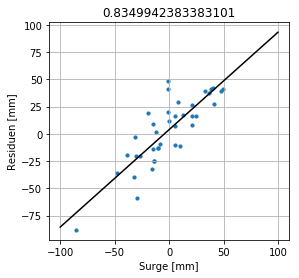

In [11]:
yearmin = 1979
indices = mean_df['year'] >= yearmin
#print(indices)

fig, ax = plt.subplots()

xdata = mean_df.loc[indices, 'surge'].values

ydata = linear_fit.resid.tail(len(xdata)).values

ax.scatter(xdata, ydata, s=10)
ax.grid()
ax.set_ylabel('Residuen [mm]')
ax.set_xlabel('Surge [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(xdata, ydata, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(xdata, ydata)[0, 1])
print(np.square(np.corrcoef(xdata, ydata)[0, 1]))

The correlation coefficient is about 0.83 and so the storm surge explains about 70% of the variation in the residuals.

Next we compare the annual sea level to the annual storm surge.

0.41436779020359554


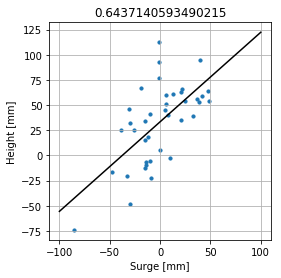

In [12]:
yearmin = 1979
indices = mean_df['year'] >= yearmin

fig, ax = plt.subplots()

ax.scatter(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, s=10)
ax.grid()
ax.set_xlabel('Surge [mm]')
ax.set_ylabel('Height [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values)[0, 1])
print(np.square(np.corrcoef(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values)[0, 1]))

Again, we find that a large part of the variation in the annual sea level can be explained by the yearly variation in storm surge. Hence, we define a linear model with the (modelled) storm surge as an explanatory variable. That is, 

sea water level ~ constant + trend + 18,613 nodal cycle + storm surge (model with storm surge)

In [13]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    
    # OLS
    #model = sm.OLS(y, X, missing='drop')
    #fit = model.fit()

    # GLSAR, AR(1) specification
    model = sm.GLSAR(y, X, missing='drop', rho=1) # autocorrelation of order 1
    fit = model.fit(cov_type='HC0') # Heteroskedasticity robust standard errors
    return fit, names

In [14]:
linear_fit_with_surge, names = linear_model_with_surge(mean_df)
tables['with surge'] = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model with surge (1979-current)'
)

In [15]:
display(tables['without'])
display(tables['with wind'])
display(tables['with surge'])

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model with surge (1979-current): AIC = {linear_fit_with_surge.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Linear model without wind (1890-current)                   
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.855
Model:                          GLSAR   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     275.8
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           2.04e-54
Time:                        20:18:54   Log-Likelihood:                -606.92
No. Observations:                 127   AIC:                             1222.
Df Residuals:                     123   BIC:                             1233.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.9339      2.913     -8.217      0.000     -29.643     -18.225
Trend          1.9153      0.067     28.655      0.000       1.784       2.046
Nodal U        4.9877      3.704      1.347      0.178      -2.271      12.247
Nodal V      -12.7148      3.518     -3.614      0.000     -19.611      -5.819
==============================================================================
Omnibus:                        3.685   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.347
Skew:                          -0.395   Prob(JB):                        0.188
Kurtosis:                       3.084   Cond. No.                         57.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.909
Model:                          GLSAR   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     354.1
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           1.90e-70
Time:                        20:18:54   Log-Likelihood:                -577.70
No. Observations:                 127   AIC:                             1167.
Df Residuals:                     121   BIC:                             1184.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -70.7314      5.365    -13.184      0.000     -81.247     -60.216
Trend          1.8636      0.055     33.627      0.000       1.755       1.972
Nodal U        3.5117      2.859      1.228      0.219      -2.092       9.115
Nodal V      -12.0050      2.882     -4.166      0.000     -17.654      -6.356
Wind $u^2$     7.3026      0.731      9.986      0.000       5.869       8.736
Wind $v^2$     0.0290      1.092      0.027      0.979      -2.112       2.170
==============================================================================
Omnibus:                        2.182   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                1.735
Skew:                          -0.152   Prob(JB):                        0.420
Kurtosis:                       3.485   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with surge (1979-current)                    
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.891
Model:                          GLSAR   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     401.0
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           3.73e-69
Time:                        20:18:56   Log-Likelihood:                -589.27
No. Observations:                 127   AIC:                             1189.
Df Residuals:                     122   BIC:                             1203.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.0547      2.240    -10.293      0.000     -27.445     -18.665
Trend          1.9173      0.056     34.408      0.000       1.808       2.027
Nodal U        4.3569      3.112      1.400      0.161      -1.742      10.456
Nodal V      -11.2371      3.212     -3.499      0.000     -17.532      -4.942
Surge          0.9006      0.069     13.122      0.000       0.766       1.035
==============================================================================
Omnibus:                        3.483   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.966
Skew:                          -0.283   Prob(JB):                        0.227
Kurtosis:                       3.489   Cond. No.                         57.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Linear model without wind or surge (1890-current): AIC = 1221.8375172201627
Linear model with wind (1948-current): AIC = 1167.4049778949807
Linear model with surge (1979-current): AIC = 1188.5444427764655


Note that the model with surge is also fitted with GLSAR - AR(1) specification.

The coefficient of the surge (0.9009) is close to 1. The null hypothesis that is equals 1 cannot be rejected at a significance level of 5%. This means that we can just subtract the storm surge values from the sea water levels.

We can now compare the AIC values of the models with wind and with surge. This comparison is not really fair, because the model with surge uses far more 'average' values than the models with wind. This might be the explanation that the model with corrected wind performs better than the model with surge.

In [16]:
# plot the models again 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level (linear model without wind)', 
    color='green',
    line_dash='dashed',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with wind)'
)

fig.line(
    linear_fit_with_surge.model.exog[:, 1] + 1970, 
    linear_fit_with_surge.predict(), 
    line_width=3, 
    legend='Current sea level (linear model with surge)', 
    color='red',
    alpha=0.5
)

#fig.circle(
#    mean_df_corrected.year[mean_df_corrected.year >= 1979],
#    mean_df_corrected.height[mean_df_corrected.year >= 1979],
#    line_width=1,
#    legend='Annual sea level corrected for storm surge (data)',
#    color='orange',
#    alpha=0.5
#)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

The plot shows that the model with wind and the model with storm surge correction both perform quite well in the period 1979-now. As shown before the AIC-value of the model with surge is lower than the AIC-value of the model with wind. The (only) difference between these models is that the number of wind observations is higher than the number of storm surge observations. Note again that mean values have been used to fill up the wind and storm surge variables before the year 1948 and 1979, respectively. 

To make a fair comparison we define a wind data set with mean values in the same years as the storm surge data set (before the year 1979) and perform a regression on this new wind data set. Next we compare the AIC-value again with that of the model with surge.

In [17]:
df1979 = mean_df.copy()

for col in ['u2', 'v2']:
    df1979.loc[df1979['year'] < 1979, col] = df1979.at[0, col]
    
display(df1979.loc[80:100])

,year,height,u,v,u2,v2,surge
80,1970,-9.833333,2.061359,0.284011,6.287304,2.305709,-0.960549
81,1971,-60.166667,1.054971,-0.074425,6.287304,2.305709,-0.960549
82,1972,-88.333333,0.580966,0.754282,6.287304,2.305709,-0.960549
83,1973,-20.500000,2.287425,-0.576052,6.287304,2.305709,-0.960549
84,1974,-16.666667,2.115610,0.586363,6.287304,2.305709,-0.960549
85,1975,-52.000000,1.162257,-0.147585,6.287304,2.305709,-0.960549
86,1976,-75.500000,0.709032,-0.120357,6.287304,2.305709,-0.960549
87,1977,-24.166667,1.855726,0.693890,6.287304,2.305709,-0.960549
88,1978,-31.833333,1.814568,0.416200,6.287304,2.305709,-0.960549
89,1979,-22.333333,1.703954,0.989679,5.700246,2.386962,-8.655717


In [18]:
linear_with_wind_fit, names = linear_model(df1979, with_wind=True, with_season=False)

table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1979-current)'
)
display(table)

linear_fit_with_surge, names = linear_model_with_surge(mean_df)
table = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model with surge (1979-current)'
)
display(table)

print(f'Linear model with wind (1979-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model with surge (1979-current): AIC = {linear_fit_with_surge.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1979-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                          GLSAR   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     347.6
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           5.41e-70
Time:                        20:18:56   Log-Likelihood:                -588.53
No. Observations:                 127   AIC:                             1189.
Df Residuals:                     121   BIC:                             1206.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -79.6121      7.228    -11.015      0.000     -93.778     -65.446
Trend          1.8461      0.059     31.192      0.000       1.730       1.962
Nodal U        4.9512      3.064      1.616      0.106      -1.053      10.956
Nodal V      -11.8143      3.221     -3.668      0.000     -18.128      -5.501
Wind $u^2$     8.0575      0.905      8.907      0.000       6.285       9.830
Wind $v^2$     0.7578      1.361      0.557      0.578      -1.910       3.426
==============================================================================
Omnibus:                        2.322   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.805
Skew:                          -0.255   Prob(JB):                        0.405
Kurtosis:                       3.285   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with surge (1979-current)                    
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.891
Model:                          GLSAR   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     401.0
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           3.73e-69
Time:                        20:18:56   Log-Likelihood:                -589.27
No. Observations:                 127   AIC:                             1189.
Df Residuals:                     122   BIC:                             1203.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.0547      2.240    -10.293      0.000     -27.445     -18.665
Trend          1.9173      0.056     34.408      0.000       1.808       2.027
Nodal U        4.3569      3.112      1.400      0.161      -1.742      10.456
Nodal V      -11.2371      3.212     -3.499      0.000     -17.532      -4.942
Surge          0.9006      0.069     13.122      0.000       0.766       1.035
==============================================================================
Omnibus:                        3.483   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.966
Skew:                          -0.283   Prob(JB):                        0.227
Kurtosis:                       3.489   Cond. No.                         57.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Linear model with wind (1979-current): AIC = 1189.0665516092213
Linear model with surge (1979-current): AIC = 1188.5444427764655


The AIC-value of the model with surge is slightly lower, suggesting that the fit of this model is slightly better. 

Finally, let us show the plots of the regression lines.

In [19]:
# plot the models again 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Annual mean sea level (data)',
    color='black',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level (linear model with wind)',
    color='blue'
)

fig.line(
    linear_fit_with_surge.model.exog[:, 1] + 1970, 
    linear_fit_with_surge.predict(), 
    line_width=3, 
    legend='Current sea level (linear model with surge)', 
    color='red',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'
#fig.legend.click_policy = "hide"

bokeh.io.show(fig)

### Conclusion

The model with storm surge is a useful alternative for the model with wind